In [1]:
## Import necessary stuff. 

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Special imports
import utils
import logomaker
from numpyro.diagnostics import hpdi

#%matplotlib inline

#model_type = 'A'    # For Fig. 3C-H
model_type = 'C'    # For Fig. 3S3

In [2]:
# Set figure style
style_file_name = f'fig.style'
s = """
axes.linewidth:     1.0  # width of spines 
font.size:          7.0  # default font size
axes.labelsize:     7.0  # fontsize of the x any y labels
axes.titlesize:     7.0  # fontsize of title
xtick.labelsize:    7.0  # fontsize of the tick labels
ytick.labelsize:    7.0  # fontsize of the tick labels
legend.fontsize:      7.0
legend.borderpad:     0.2  # border whitespace
legend.labelspacing:  0.2  # the vertical space between the legend entries
legend.borderaxespad: 0.2  # the border between the axes and legend edge
axes.labelpad:      1.0     # space between label and axis
"""
with open(style_file_name, 'w') as f:
    f.write(s)
    
plt.style.use(style_file_name)

In [3]:
# Load measurements
measurement_df = pd.read_csv('measurement_df.csv', index_col=0)
measurement_df.head()

,ss,log_E_risdiplam,dlog_E_risdiplam,log_E_branaplam,dlog_E_branaplam,log_psi_dmso,log_psi_risdiplam,log_psi_branaplam,use_for_mpsa_fit,use_for_rnaseq_fit
0,AAAA/GUAAAA,0.508591,0.362189,1.437003,0.349206,NaN,NaN,NaN,False,True
1,AAAA/GUAAAG,0.725740,0.422907,0.215219,0.393041,NaN,NaN,NaN,False,True
2,AAAA/GUAAAU,0.121753,0.221160,0.795931,0.216936,NaN,NaN,NaN,False,True
3,AAAA/GUAACA,0.252730,0.753580,0.495291,0.704470,NaN,NaN,NaN,False,True
4,AAAA/GUAACU,-0.020570,0.284461,0.436673,0.278890,NaN,NaN,NaN,False,True


In [4]:
# Load posterior samples
file_name = f'joint_model_{model_type}_v2.pkl'
with open(file_name, 'rb') as f:
    mcmc_samples = pickle.load(f)
print(f'Loaded mcmc samples from: {file_name}')
#mcmc_samples.keys()

Loaded mcmc samples from: joint_model_C_v2.pkl


In [5]:
# To convert samples to logos
def samples_to_logo_df(theta_lc_samples):
    theta_lc_mean = np.array(theta_lc_samples.mean(axis=0))
    logo_df =  pd.DataFrame(theta_lc_mean, columns=['A', 'C', 'G', 'U'])
    zeros_df = pd.DataFrame(np.zeros([2,4]), columns=['A', 'C', 'G', 'U'])
    logo_df = pd.concat([logo_df.iloc[:4,:], zeros_df, logo_df.iloc[4:]], axis=0).reset_index(drop=True)
    logo_df.index = range(-4,6)    
    return logo_df

# Define plotting function
def plot_theta_logo(theta_lc_samples, ax, title, subscript):
    theta_lc_mean_df=samples_to_logo_df(theta_lc_samples)
    logo = logomaker.Logo(theta_lc_mean_df, ax=ax, center_values=True, show_spines=True, 
                          font_name='Arial Rounded MT Bold')
    logo.highlight_position_range(pmin=0, pmax=1, color='w', zorder=1)
    #ylim = [-10,10]
    ylim = [-6, 6]
    xlim = [-4.6, 5.6]
    #ylim = ax.get_ylim()
    logomaker.Glyph(ax=ax, p=0, c='G', color='k', floor=ylim[0]+.5, ceiling=ylim[1]-.5,
                    font_name='Arial Rounded MT Bold')
    logomaker.Glyph(ax=ax, p=1, c='U', color='k', floor=ylim[0]+.5, ceiling=ylim[1]-.5,
                    font_name='Arial Rounded MT Bold')
    ax.set_title(title);
    ax.set_xticks(theta_lc_mean_df.index)
    x_ticks_labels = ['−4', '−3', '−2', '−1', '+1', '+2', '+3', '+4', '+5', '+6']
    ax.set_xticklabels(x_ticks_labels, fontweight='bold')
    #ax.set_xticks([])
    ax.tick_params('x', length=0)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_ylabel(fr'- $\Delta \Delta G_\mathrm{{{subscript}}}$' + '\n(kcal/mol)', labelpad=0, va='bottom')
#     for axis in ['top','bottom','left','right']:
#         ax.spines[axis].set_linewidth(0.5)
    ax.axvline(-.5, linestyle='--', color='k', linewidth=1)

In [6]:
5/1.62

3.0864197530864197

In [7]:
def plot_theta_intervals_horizontal(ax, theta_lc_samples, subscript):

    # From logomaker
    # See logomaker.src.colors.COLOR_SCHEME_DICT
    char_to_color_dict = {'G': [1, 0.65, 0],
                          'U': [1, 0, 0],
                          'C': [0, 0, 1],
                          'A': [0, 0.5, 0]}
    
    theta_lc_mean = theta_lc_samples.mean(axis=0)
    theta_lc_hpdi = hpdi(theta_lc_samples, prob=.8, axis=0)
    
    xlim = [-4.6, 5.6]
    #ylim = [-5, 5]
    ylim = [-3, 3]
    #yticks = [-5, 0, 5]
    yticks = [-3, 0, 3]
    
    xticks = np.arange(-4,6)
    xticklabels = []
    bases = list('ACGU')
    i=0
    for xtick in xticks:
        if xtick not in [0, 1]:
            for j, base in enumerate(bases):
                x = xtick + 0.25*(j-1.5)
                y = theta_lc_mean[i,j]
                y_clipped = np.clip(y, ylim[0]+.3, ylim[1]-.3)
                if y!=y_clipped:
                    marker_kwargs = dict(marker='s', markersize=4.5)
                else:
                    marker_kwargs = dict(marker='o', markersize=3)
                y_lo = theta_lc_hpdi[0,i,j]
                y_hi = theta_lc_hpdi[1,i,j]

                color=char_to_color_dict[base]
                ax.plot(x, y_clipped, color=color, **marker_kwargs)
                ax.plot([x, x], [y_lo, y_hi], '-', linewidth=1, color=color)
            
                if i==0:
                    ax.text(x=x-.05, y=ylim[1]-.3, s=base, ha='center', va='top', 
                            fontsize=6, color=color, fontweight='bold')
            
            i += 1
            
        if xtick==0:
            ax.axvline(xtick-.5,linestyle='--', linewidth=1, color='k', zorder=-100)
        elif xtick > -4:
            ax.axvline(xtick-.5,linestyle=':', linewidth=.5, color='k', zorder=-100)
        xticklabels.append(f'{xtick+(xtick>=0):+d}')
    
    ax.set(xticks=xticks, yticks=yticks)
    ax.tick_params('x', length=0)
    #ax.set_xticklabels(xticklabels)
    ax.set_xticks([])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_ylabel(fr'- $\Delta \Delta G_\mathrm{{{subscript}}}$' + '\n(kcal/mol)', labelpad=0, va='bottom')
    ax.axhline(0,linestyle=':', linewidth=.5, color='k', zorder=-100)

In [8]:
def my_rsq(x_values, y_values):
    correlation_matrix = np.corrcoef(x_values, y_values)
    correlation_xy = correlation_matrix[0,1]
    r_squared = correlation_xy**2
    return r_squared

def plot_scatter(ax, log_x, log_y, xlim, ylim, title='', **kwargs):
    
    rsq = my_rsq(log_x, log_y)
    x = np.exp(np.array(log_x))
    y = np.exp(np.array(log_y))
    ax.scatter(x,y, alpha=.5, linewidth=0, s=10)
    dy = ylim[1]/ylim[0]
    dx = xlim[1]/xlim[0]
    ax.plot(xlim, xlim, '--k', linewidth=.5)
    ax.set(xlim=xlim,
           ylim=ylim,
           **kwargs)
    ax.set_title(title)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.text(s=f'$R^2$: {rsq:.3f}',
           x=xlim[0]*(dx**.02), y=ylim[1]/(dy**.02), ha='left', va='top', fontsize=7)
     

In [9]:
# Process stored info

# conversion facto
conv_factor = 1/1.62 # put into units of kcal/mol

# Get theta_lc samples and fix gauge
theta_lc_samples_ris = np.array(mcmc_samples['theta_lc_ris'])
theta_lc_samples_ris = theta_lc_samples_ris - theta_lc_samples_ris.mean(axis=2)[:,:,np.newaxis]
theta_lc_samples_ris *= conv_factor

theta_lc_samples_hyp = np.array(mcmc_samples['theta_lc_hyp'])
theta_lc_samples_hyp = theta_lc_samples_hyp - theta_lc_samples_hyp.mean(axis=2)[:,:,np.newaxis]
theta_lc_samples_hyp *= conv_factor

# log_E (measured vs. predicted) for risdiplam, branaplam
ix = measurement_df['use_for_rnaseq_fit']

log_E_ris_model = np.log(np.array(mcmc_samples['E_ris'].mean(axis=0)))[ix]
log_E_ris_data = measurement_df['log_E_risdiplam'].values[ix]

log_E_bra_model = np.log(np.array(mcmc_samples['E_bra'].mean(axis=0)))[ix]
log_E_bra_data = measurement_df['log_E_branaplam'].values[ix]

# log_psi (measured vs. predicted) for risdiplam, branaplam
ix = measurement_df['use_for_mpsa_fit']

log_psi_ris_model = np.array(mcmc_samples['log_psi_ris'].mean(axis=0))[ix]
log_psi_ris_data = measurement_df['log_psi_risdiplam'].values[ix]

log_psi_bra_model = np.array(mcmc_samples['log_psi_bra'].mean(axis=0))[ix]
log_psi_bra_data = measurement_df['log_psi_branaplam'].values[ix]

Figure saved to figS6.pdf


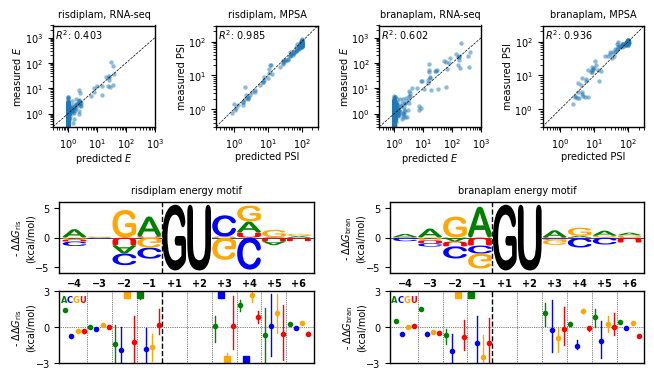

In [10]:
# Plot logos together with theta intervals
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=[6.5,3.75])

#gs1 = GridSpec(2, 2, top=.94, bottom=0.50, left=.07, right=.98, wspace=0.2, hspace=.25)
gs1 = GridSpec(2, 2, top=.48, bottom=0.05, left=.08, right=.98, wspace=0.3, hspace=.25)

plot_theta_logo(theta_lc_samples=theta_lc_samples_ris, 
                ax=fig.add_subplot(gs1[0,0]), 
                title='risdiplam energy motif',
                subscript='ris')
plot_theta_intervals_horizontal(
                ax=fig.add_subplot(gs1[1,0]), 
                theta_lc_samples=theta_lc_samples_ris,
                subscript='ris')

if model_type == 'A':
    title = 'hyper-activation energy motif'
    subscript='hyp'
# elif model_type == 'B':
#     title = 'bra motif − ris motif'
elif model_type == 'C':
    title = 'branaplam energy motif'
    subscript='bran'

plot_theta_logo(theta_lc_samples=theta_lc_samples_hyp, 
                ax=fig.add_subplot(gs1[0,1]), 
                title=title,
                subscript=subscript)
plot_theta_intervals_horizontal(
                ax=fig.add_subplot(gs1[1,1]), 
                theta_lc_samples=theta_lc_samples_hyp,
                subscript=subscript)

rnaseq_kwargs = dict(xlim=[.3,1000],
                     ylim=[.3,3000],
                     xticks=[1, 10, 100, 1000],
                     yticks=[1, 10, 100, 1000],
                     xlabel='predicted $E$',
                     ylabel='measured $E$',)

mpsa_kwargs = dict(xlim=[.3,300],
                   ylim=[.3,300],
                   xticks=[1, 10, 100],
                   yticks=[1, 10, 100],
                   xlabel='predicted PSI',
                   ylabel='measured PSI',)

#gs2 = GridSpec(1, 4, top=.40, bottom=0.1, left=.07, right=.98, wspace=0.5)
gs2 = GridSpec(1, 4, top=.95, bottom=0.68, left=.07, right=.98, wspace=0.6)

plot_scatter(ax=fig.add_subplot(gs2[0,0]),
             log_x=log_E_ris_model,
             log_y=log_E_ris_data,
             title='risdiplam, RNA-seq',
             **rnaseq_kwargs)
    
plot_scatter(ax=fig.add_subplot(gs2[0,1]),
             log_x=log_psi_ris_model,
             log_y=log_psi_ris_data,
             title='risdiplam, MPSA',
             **mpsa_kwargs)
    
plot_scatter(ax=fig.add_subplot(gs2[0,2]),
             log_x=log_E_bra_model,
             log_y=log_E_bra_data,
             title='branaplam, RNA-seq',
             **rnaseq_kwargs)

plot_scatter(ax=fig.add_subplot(gs2[0,3]),
             log_x=log_psi_bra_model,
             log_y=log_psi_bra_data,
             title='branaplam, MPSA',
             **mpsa_kwargs)

if model_type=='A':
    file_name = 'fig3C-H.pdf'
elif model_type=='C':
    file_name = 'figS6.pdf'
print(f'Figure saved to {file_name}')
fig.savefig(file_name)